# Claws Vs Paws
---- Image classification from scratch

Author : Neeraj Balodi
Description : This repository features a cutting-edge deep learning model trained on extensive datasets of cats and dogs for precise classification.

## Reference Links -
1. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
2. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
3. https://stackoverflow.com/questions/56450969/how-to-calculate-output-sizes-after-a-convolution-layer-in-a-configuration-file
4. https://www.tensorflow.org/api_docs/python/tf/keras/Model

### Dataset Link
Credits to - https://www.kaggle.com/datasets/salader/dogs-vs-cats?select=train

In [1]:
!mkdir /root/.kaggle/
!cp kaggle.json /root/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:08<00:00, 274MB/s]
100% 1.06G/1.06G [00:08<00:00, 131MB/s]


In [3]:
!unzip /content/dogs-vs-cats.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/dogs/dog.4419.jpg  
  inflating: /content/train/dogs/dog.442.jpg  
  inflating: /content/train/dogs/dog.4420.jpg  
  inflating: /content/train/dogs/dog.4421.jpg  
  inflating: /content/train/dogs/dog.4422.jpg  
  inflating: /content/train/dogs/dog.4424.jpg  
  inflating: /content/train/dogs/dog.4425.jpg  
  inflating: /content/train/dogs/dog.4426.jpg  
  inflating: /content/train/dogs/dog.4427.jpg  
  inflating: /content/train/dogs/dog.4431.jpg  
  inflating: /content/train/dogs/dog.4433.jpg  
  inflating: /content/train/dogs/dog.4436.jpg  
  inflating: /content/train/dogs/dog.4438.jpg  
  inflating: /content/train/dogs/dog.4439.jpg  
  inflating: /content/train/dogs/dog.444.jpg  
  inflating: /content/train/dogs/dog.4440.jpg  
  inflating: /content/train/dogs/dog.4441.jpg  
  inflating: /content/train/dogs/dog.4442.jpg  
  inflating: /content/train/dogs/dog.4443.jpg  
  inflating: /content/train/dogs/dog.44

# Importing Packages

In [4]:
from PIL import Image
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.models import load_model


## Reading the Data

In [5]:
def plot_images_from_directory(directory_path, class_animal, num_images=9):
  image_filenames = os.listdir(directory_path)

  if len(image_filenames) < num_images:
    print(f'Only found {len(image_filenames)} images in {directory_path}, displaying them all')
    num_images = len(image_filenames)

  selected_iamges = random.sample(image_filenames, num_images)

  fig, axes = plt.subplots(3,3, figsize = (8,8))
  axes = axes.ravel()

  for i, image_file in enumerate(selected_iamges):
    image_path = os.path.join(directory_path, image_file)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_animal}")
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()


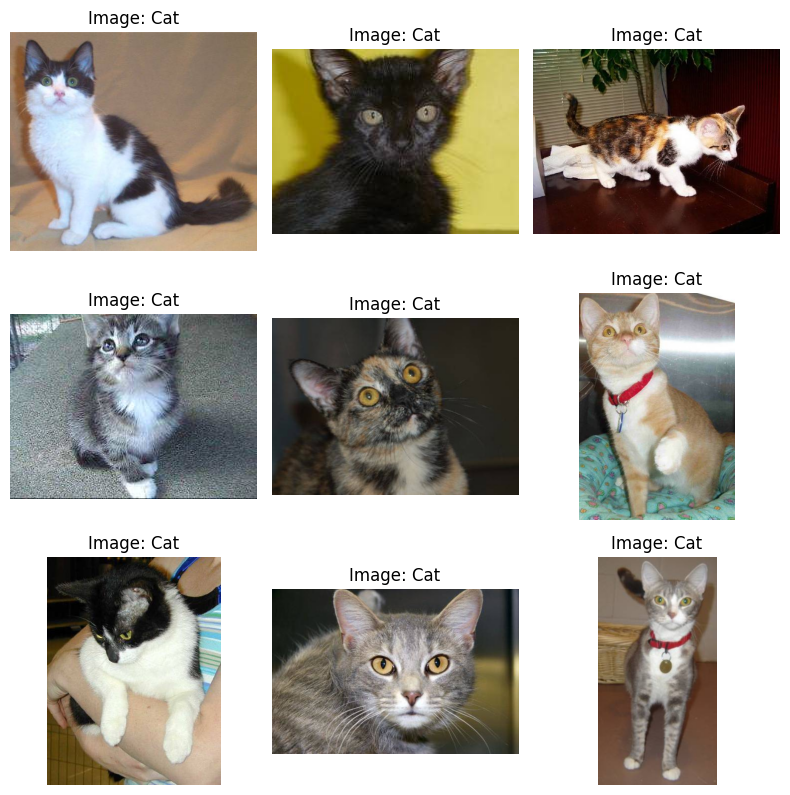

In [6]:
cat_directory_path = '/content/dogs_vs_cats/train/cats'

plot_images_from_directory(cat_directory_path, class_animal = 'Cat')

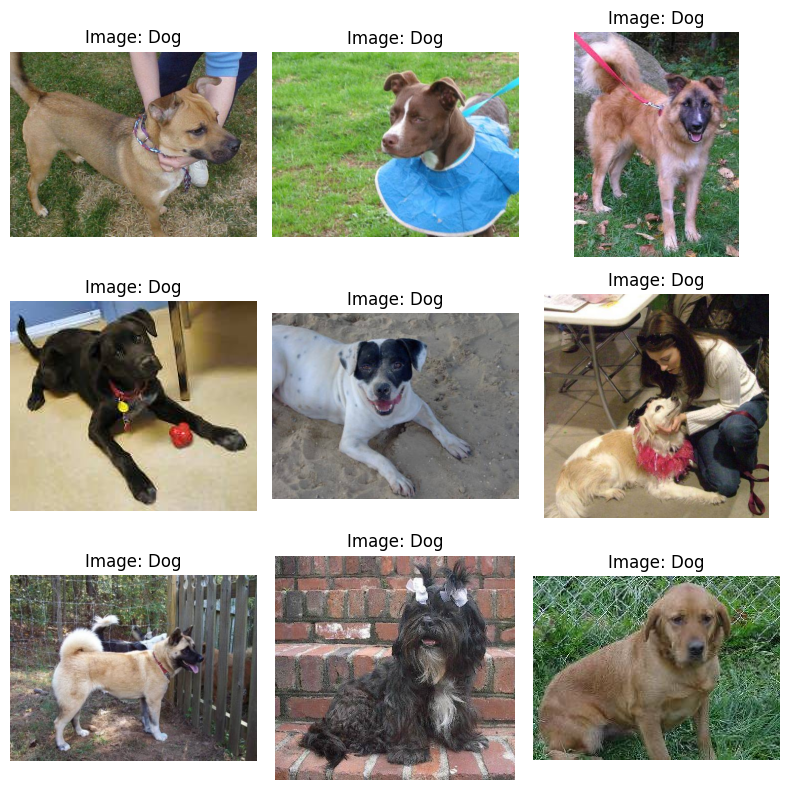

In [7]:
dog_directory_path = '/content/dogs_vs_cats/train/dogs'

plot_images_from_directory(dog_directory_path, class_animal = 'Dog')

## Data Analysis

In [8]:
cat_images = os.listdir(cat_directory_path)
dog_images = os.listdir(dog_directory_path)

classes_animals = ['Cats', 'Dogs']
count = [len(cat_images), len(dog_images)]

print(count)

[10000, 10000]


## Removing Corrupted Images

In [9]:
import cv2
import imghdr

image_exts = ['jpeg', 'jpg','png']

data_dir = '/content/dogs_vs_cats'

for root, dirs, files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root, file)

    try:
      file_type = imghdr.what(file_path)

      if file_type not in image_exts:
        print(f'Image not in ext list {file_path}')
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)

    except Exception as e:
      print(f'Issue with file {file_path}. Error: {e}')
      os.remove(file_path)

### Loading Shapes and Channels

In [10]:
def image_to_array(image_path):
  try:
    with Image.open(image_path) as img:
      image_array = np.array(img)
      return image_array
  except IOError:
    print(f'Could not read the image file at {image_path}')
    return None

array([[[ 28,  32,  33],
        [ 26,  30,  31],
        [ 24,  28,  29],
        ...,
        [ 75,  52,  38],
        [ 71,  48,  34],
        [ 66,  43,  29]],

       [[ 21,  25,  26],
        [ 20,  24,  25],
        [ 19,  23,  24],
        ...,
        [ 76,  53,  39],
        [ 73,  51,  37],
        [ 72,  50,  36]],

       [[ 63,  67,  68],
        [ 63,  67,  68],
        [ 64,  68,  69],
        ...,
        [ 66,  44,  30],
        [ 65,  46,  31],
        [ 69,  50,  35]],

       ...,

       [[176, 164, 150],
        [178, 166, 152],
        [185, 173, 159],
        ...,
        [202, 186, 173],
        [202, 186, 170],
        [203, 188, 169]],

       [[179, 167, 153],
        [181, 169, 155],
        [190, 178, 164],
        ...,
        [207, 191, 178],
        [207, 191, 175],
        [206, 191, 172]],

       [[183, 171, 157],
        [184, 172, 158],
        [192, 180, 166],
        ...,
        [204, 188, 175],
        [203, 187, 171],
        [203, 188, 169]]], dtype=uint8)
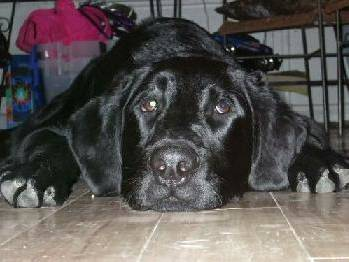

In [11]:
image_to_array('/content/dogs_vs_cats/train/dogs/dog.996.jpg')

# Building Model

In [12]:
base_dir = '/content/dogs_vs_cats/train'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [13]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary',
    subset = 'training'
)


Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


## Getting Class Labels

In [14]:
train_class_labels = train_generator.class_indices
print('Training class labels: ', train_class_labels)

validation_class_labels = validation_generator.class_indices
print('Validation class labels: ', validation_class_labels)

Training class labels:  {'cats': 0, 'dogs': 1}
Validation class labels:  {'cats': 0, 'dogs': 1}


In [15]:
train_generator.reset()

# 1. Basic CNN model

In [16]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu',
    input_shape = (150,150, 3)),

    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation = 'relu',
    input_shape = (150,150, 3)),

    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation = 'relu',
    input_shape = (150,150, 3)),

    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation = 'relu',
    input_shape = (150,150, 3)),

    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation = 'sigmoid') # Sigmoid activation for binary classification

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
batch = 20
train_steps = np.ceil(train_generator.samples / batch)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch)
print(train_steps, validation_steps_per_epoch)

800.0 800.0


In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
800/800 [==============================] - 61s 69ms/step - loss: 0.6469 - accuracy: 0.6093 - val_loss: 0.5568 - val_accuracy: 0.7039
Epoch 2/10
800/800 [==============================] - 69s 86ms/step - loss: 0.5556 - accuracy: 0.7154 - val_loss: 0.5324 - val_accuracy: 0.7387
Epoch 3/10
800/800 [==============================] - 53s 67ms/step - loss: 0.4640 - accuracy: 0.7826 - val_loss: 0.3830 - val_accuracy: 0.8276
Epoch 4/10
800/800 [==============================] - 54s 67ms/step - loss: 0.3806 - accuracy: 0.8316 - val_loss: 0.3052 - val_accuracy: 0.8678
Epoch 5/10
800/800 [==============================] - 54s 68ms/step - loss: 0.3182 - accuracy: 0.8606 - val_loss: 0.2766 - val_accuracy: 0.8829
Epoch 6/10
800/800 [==============================] - 55s 68ms/step - loss: 0.2618 - accuracy: 0.8879 - val_loss: 0.1910 - val_accuracy: 0.9279
Epoch 7/10
800/800 [==============================] - 70s 88ms/step - loss: 0.1930 - accuracy: 0.9199 - val_loss: 0.1426 - val_accuracy:

In [20]:
model.save('cats_vs_dogs_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


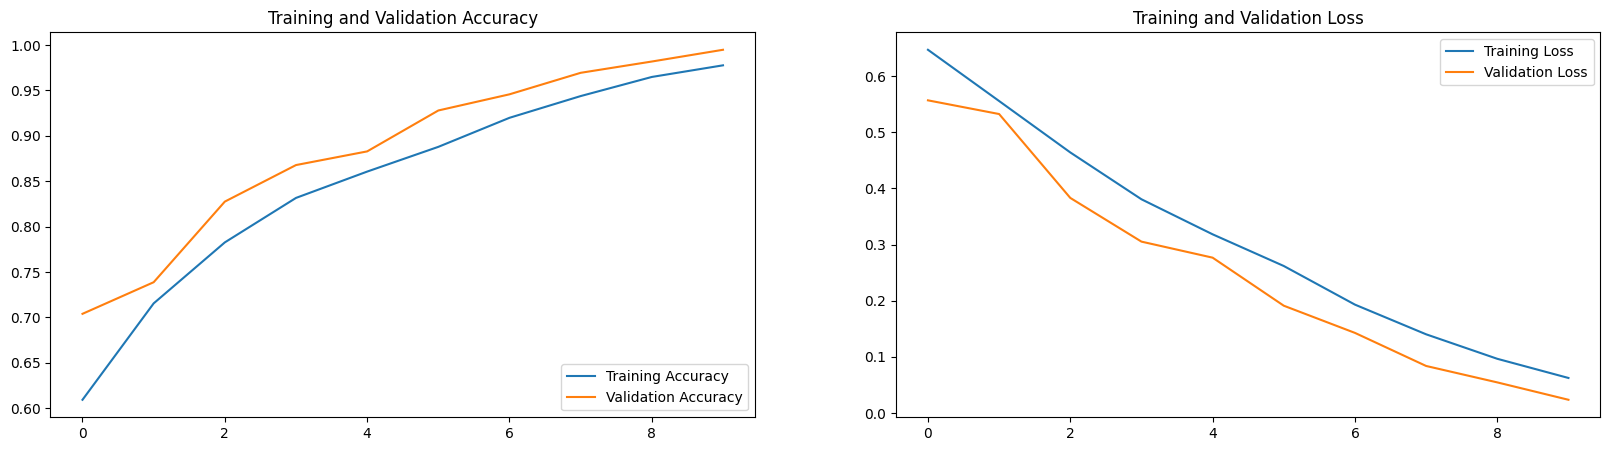

In [21]:
# Plot the training and validation accuracy/loss from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Evaluation

### Initiating Test Generator

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = '/content/dogs_vs_cats/test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


## Making test predictions

In [23]:
probabilities = model.predict(test_generator,steps=np.ceil(test_generator.samples/test_generator.batch_size))

probabilities

250/250 [==============================] - 8s 31ms/step


array([[5.6867156e-14],
       [4.6784640e-04],
       [5.3631362e-07],
       ...,
       [6.4392108e-01],
       [9.6007508e-01],
       [9.4772011e-01]], dtype=float32)

In [24]:
# Reset the test generator
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes

# Predict probabilities for the positive class
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))

# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

250/250 [==============================] - 8s 31ms/step


array([0, 0, 0, ..., 1, 1, 1])

## Plotting Confusion Matrix

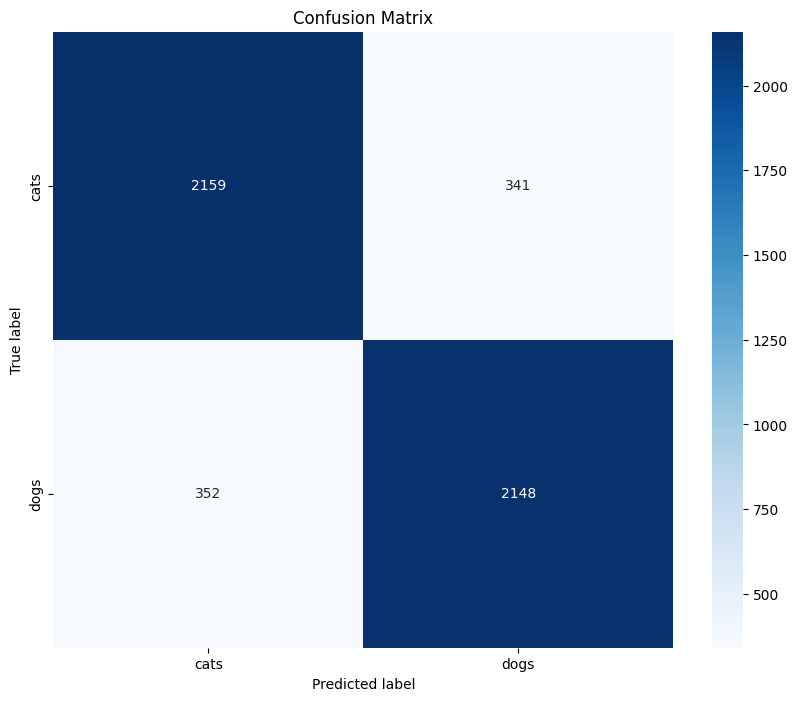

In [25]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Inference

In [26]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Test loss: {loss:.2f}")

250/250 [==============================] - 9s 34ms/step - loss: 0.5221 - accuracy: 0.8614
Test accuracy: 86.14%
Test loss: 0.52


## Single Image Prediction

In [27]:
def make_prediction(image_path):
    img = load_img(image_path, target_size=(150, 150))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Dog')
    else:
        plt.title('Predicted: Cat')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 359ms/step
Prediction: [[0.9958911]]


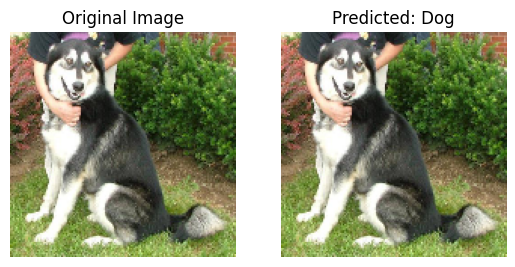

In [29]:
img_path = '/content/dogs_vs_cats/test/dogs/dog.10021.jpg'
make_prediction(img_path)

In [30]:
# Reset the test_generator before making predictions
test_generator.reset()

# Predict the whole test set
predictions = model.predict(test_generator, verbose=1)

# The predictions will be in the format of probabilities. You'll need to convert these to binary labels (0 or 1) based on a 0.5 threshold.
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_count = len(misclassified_indices)
print(f"Total misclassifications in the test set: {misclassified_count} out of {len(true_classes)}")

250/250 [==============================] - 12s 48ms/step
Total misclassifications in the test set: 693 out of 5000


250/250 [==============================] - 8s 31ms/step
Total misclassifications: 693


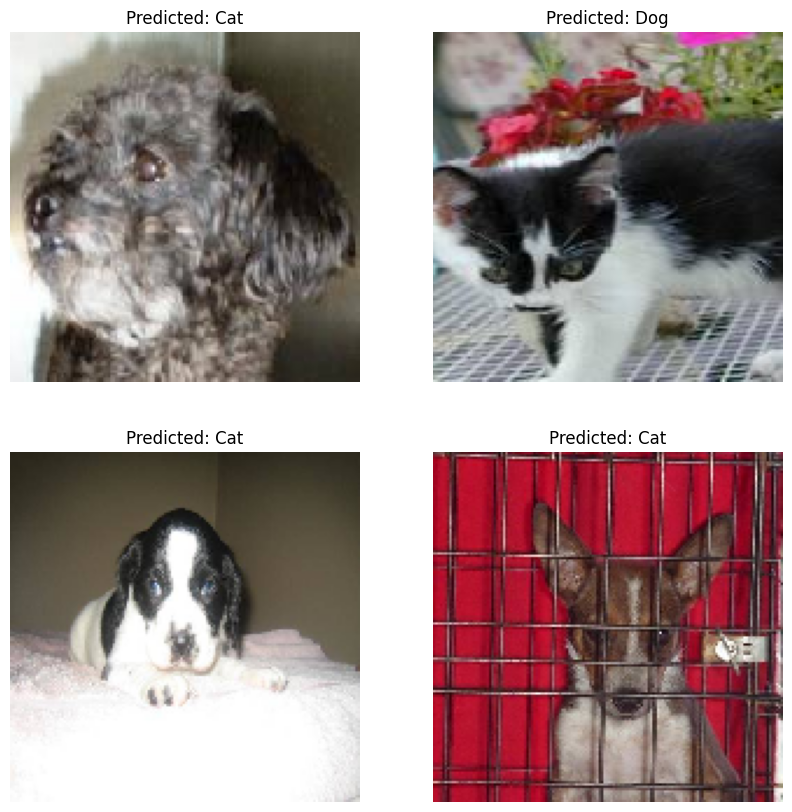

In [31]:
# Generate predictions for all test images
predictions = model.predict(test_generator)

# Convert predictions to binary (0 or 1) based on a 0.5 threshold
predicted_classes = predictions > 0.5

# Retrieve the true labels from the generator
true_classes = test_generator.classes

filenames = test_generator.filenames
misclassified_indices = np.where(predicted_classes.flatten() != true_classes)[0]

print(f"Total misclassifications: {len(misclassified_indices)}")


# Select a random subset of misclassified images
num_samples_to_display = 4
random_indices = random.sample(list(misclassified_indices), num_samples_to_display)

# Plot
plt.figure(figsize=(10, 10))
for i, index in enumerate(random_indices, 1):
    # Load image
    img_path = test_dir + '/' + filenames[index]
    img = load_img(img_path, target_size=(150, 150))

    # Predicted class
    predicted_class = "Dog" if predicted_classes[index] else "Cat"

    # Display
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
plt.show()